In [ ]:
import pandas as pd
import yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from modeling import update_config

In [3]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

In [4]:
team = pd.read_csv('data/agg/team_stats.csv', index_col=0)
opp = pd.read_csv('data/agg/opp_stats.csv', index_col=0)
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [66]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp["year"] = pbp["game_id"].apply(lambda x: int(x.split("_")[0]))
pbp = pbp.merge(team, left_on=['posteam','season','week'], right_on=['recent_team','season','week']).drop('recent_team',axis=1)
pbp = pbp.merge(opp, left_on=['defteam','season','week'], right_on=['opponent_team','season','week']).drop('opponent_team',axis=1)
pbp.sample(5)
pbp.loc[pbp.home_team == pbp.posteam, ['spread_line']] = pbp.loc[pbp.home_team == pbp.posteam, ['spread_line']] * -1 

rushes = pbp.loc[(pbp.play_type=='run') & (~pbp.yards_gained.isna())].copy(
    deep=True
)
rushes['wind'] = rushes['wind'].fillna(8)
rushes['temp'] = rushes['temp'].fillna(50)

In [67]:
pbp.loc[
    (pbp.week==12)
    & (pbp.season==2024)
    & (pbp.home_team=='CAR')
]['spread_line']

689770   -11.0
689771   -11.0
689772   -11.0
689773   -11.0
689774   -11.0
          ... 
689937   -11.0
689938   -11.0
689939   -11.0
689940   -11.0
689941    11.0
Name: spread_line, Length: 172, dtype: float32

In [68]:
pbp['play_time_elapsed'] = pbp['quarter_seconds_remaining'] - pbp.groupby(['game_id'])['quarter_seconds_remaining'].shift(-1)
#pbp['play_time_elapsed'] =  pbp['quarter_seconds_remaining'] - pbp['play_time_elapsed']
pbp[['quarter_seconds_remaining','play_time_elapsed','time', 'play_type', 'yards_gained', 'game_id']]

,quarter_seconds_remaining,play_time_elapsed,time,play_type,yards_gained,game_id
0,900.0,5.0,15:00,kickoff,0.0,2010_01_ARI_STL
1,895.0,31.0,14:55,pass,0.0,2010_01_ARI_STL
2,864.0,41.0,14:24,run,5.0,2010_01_ARI_STL
3,823.0,26.0,13:43,pass,18.0,2010_01_ARI_STL
4,797.0,25.0,13:17,pass,17.0,2010_01_ARI_STL
...,...,...,...,...,...,...
691091,77.0,4.0,01:17,pass,-1.0,2024_12_TEN_HOU
691092,73.0,1.0,01:13,kickoff,0.0,2024_12_TEN_HOU
691093,72.0,35.0,01:12,qb_kneel,-1.0,2024_12_TEN_HOU
691094,37.0,37.0,00:37,qb_kneel,-1.0,2024_12_TEN_HOU


In [69]:
pbp.groupby(['play_type'])['play_time_elapsed'].mean()

play_type
extra_point     -1.888969
field_goal     -49.620770
kickoff         -2.894772
no_play         11.746616
pass            18.373884
punt             7.855170
qb_kneel      -169.898178
qb_spike        -3.852126
run             29.764097
Name: play_time_elapsed, dtype: float32

In [70]:
rusher_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[['season', 'team_name', 'week', 'game_type',  'gsis_id', 
       'position', 'depth_position', 'full_name', 'dense_depth',
 'carries_roll',
 'rushing_yards_roll',
 'rushing_tds_roll',
 'rushing_first_downs_roll',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']]
rushes = rushes.merge(
    rusher_stats,
    left_on=["posteam", "season", "week", "rusher_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
)
rushes

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,rushing_yards_roll,rushing_tds_roll,rushing_first_downs_roll,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_roll,fantasy_points_ppr_roll,yards_per_carry_roll
0,82.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000e+00,11.400000,15.400000,4.153846
1,156.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000e+00,11.400000,15.400000,4.153846
2,201.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000e+00,11.400000,15.400000,4.153846
3,222.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000e+00,11.400000,15.400000,4.153846
4,278.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,81.000000,0.000000,6.000000,4.000000,8.000000,6.000000,0.000000e+00,8.700000,12.700000,3.681818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212190,3609.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,92.194890,1.688397,4.517972,1.947200,3.440166,30.823058,6.851820e-02,22.848945,24.796145,4.560776
212191,3707.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,TEN,away,HOU,...,59.174149,0.107231,2.814312,2.866739,3.955564,16.706667,7.389258e-07,8.231430,11.098169,4.308297
212192,3978.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,92.194890,1.688397,4.517972,1.947200,3.440166,30.823058,6.851820e-02,22.848945,24.796145,4.560776
212193,4051.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,TEN,away,HOU,...,59.174149,0.107231,2.814312,2.866739,3.955564,16.706667,7.389258e-07,8.231430,11.098169,4.308297


In [71]:
rushes['play_end_ydline'] = (rushes['yardline_100'] - rushes['yards_gained'])
rushes = rushes.loc[~rushes.down.isna()].copy(deep=True)

In [72]:
game_context_cols = [
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "posteam_score",
    "defteam_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
]
team_rush_cols = [
 'rushing_yards_team_roll',
 'rushing_yards_opp_roll']

In [73]:
rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll', 'yards_per_carry_roll']] = rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']].fillna(0)


In [74]:
team_rush_cols

['rushing_yards_team_roll', 'rushing_yards_opp_roll']

In [75]:
rush_yards_cols = game_context_cols + rusher_stat_cols + team_rush_cols

In [76]:
rushes['yards_gained'].min()

-26.0

In [77]:
rushes['yards_shifted'] = rushes['yards_gained'] + 30

In [78]:

small = rushes.copy()#loc[rushes.yardline_100 < 10]

X = torch.Tensor((small[rush_yards_cols].values))
y = torch.tensor(small['yards_shifted'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(rush_yards_cols)
# Update the model to match the input and output sizes



In [79]:
class WithDropout(nn.Module):
    def __init__(self, n_in=11, n_out=109, n_hidden=50, dropout_prob=0.5):
        super(WithDropout, self).__init__()
        self.main_layers = nn.Sequential(
        nn.Linear(n_in, n_hidden),
        nn.Dropout(p=dropout_prob),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),nn.ReLU(),
        )
        self.add_yardline = nn.Linear(n_hidden + 1, n_out)
    def forward(self, x):
        # Extract the feature to pass to the final layer (e.g., the first feature)
        feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
        
        x = self.main_layers(x)
        x = torch.cat((x, feature_to_pass), dim=1) 
        x = self.add_yardline(x)
        
        return x

In [80]:

def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=512):
    # Define the model, loss function, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = WithDropout(n_in, n_out, n_hidden=n_hidden).to(device)
    criterion = nn.CrossEntropyLoss()  # Suitable for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

    # Split data into training and testing sets
    train_X, test_X = X[obs//5:].to(device), X[:obs//5].to(device)
    train_y, test_y = y[obs//5:].to(device), y[:obs//5].to(device)

    # Training loop
    epochs = epochs
    batch_size = 512

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0))
        epoch_loss = 0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = train_X[indices], train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: [batch_size, 100]
            loss = criterion(outputs, batch_y)  # batch_y must be [batch_size] with class indices
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_X):.4f}")

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_preds = model(test_X)  # Shape: [num_samples, 100]
        test_loss = criterion(test_preds, test_y).item() 
        accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return model

In [81]:
rush_yards_model = train_model(X,y, 20, 130, n_hidden = 1000, epochs=15) # 2.81, 0.1393

Epoch 1/15, Loss: 0.0132
Epoch 2/15, Loss: 0.0057
Epoch 3/15, Loss: 0.0057
Epoch 4/15, Loss: 0.0057
Epoch 5/15, Loss: 0.0057
Epoch 6/15, Loss: 0.0057
Epoch 7/15, Loss: 0.0057
Epoch 8/15, Loss: 0.0057
Epoch 9/15, Loss: 0.0057
Epoch 10/15, Loss: 0.0057
Epoch 11/15, Loss: 0.0057
Epoch 12/15, Loss: 0.0057
Epoch 13/15, Loss: 0.0057
Epoch 14/15, Loss: 0.0057
Epoch 15/15, Loss: 0.0057
Test Loss: 2.8900, Test Accuracy: 0.1292


In [82]:
rush_yards_model = rush_yards_model.to('cpu')

In [87]:
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
    'rush_yard_cols':rush_yards_cols
}
feature_config

update_config(feature_config)

In [88]:
test = rushes.loc[rushes.yardline_100==5][rush_yards_cols+ ['yards_shifted']]
test

,yardline_100,down,goal_to_go,ydstogo,posteam_score,defteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,...,temp,spread_line,total_line,carries_roll,rushing_yards_roll,fantasy_points_ppr_roll,yards_per_carry_roll,rushing_yards_team_roll,rushing_yards_opp_roll,yards_shifted
166,5.0,3.0,0,4.0,0.0,0.0,0.0,269.0,1169.0,2969.0,...,64.0,5.5,40.5,16.000000,62.000000,6.200000,3.875000,89.000000,89.000000,32.0
307,5.0,2.0,0,4.0,17.0,14.0,3.0,190.0,190.0,190.0,...,87.0,-2.5,37.0,22.000000,75.000000,11.800000,3.409091,119.000000,119.000000,33.0
416,5.0,2.0,1,5.0,0.0,0.0,0.0,632.0,1532.0,3332.0,...,75.0,-6.5,44.5,5.000000,22.000000,21.080000,4.400000,101.000000,101.000000,34.0
740,5.0,2.0,1,5.0,0.0,0.0,0.0,160.0,1060.0,2860.0,...,78.0,-4.0,45.5,19.000000,75.000000,6.700000,3.947368,109.000000,109.000000,32.0
1013,5.0,2.0,0,4.0,7.0,10.0,-3.0,614.0,614.0,2414.0,...,50.0,-7.0,41.0,9.750000,34.333333,4.308333,4.180373,69.500000,28.000000,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211687,5.0,2.0,1,5.0,0.0,0.0,0.0,592.0,1492.0,3292.0,...,50.0,3.0,51.0,4.983394,33.303888,20.009290,4.370067,112.571429,90.428571,35.0
211847,5.0,3.0,1,5.0,14.0,6.0,8.0,144.0,1044.0,1044.0,...,50.0,-7.0,50.5,13.285641,78.551508,17.572916,6.174134,150.571429,132.285714,35.0
212084,5.0,1.0,1,5.0,10.0,6.0,4.0,827.0,827.0,827.0,...,36.0,3.5,36.5,8.464598,44.788316,6.142742,5.420636,69.571429,92.285714,33.0
212090,5.0,1.0,1,5.0,6.0,18.0,-12.0,509.0,509.0,509.0,...,36.0,-3.5,36.5,1.304678,5.176026,1.031306,5.184281,139.000000,104.142857,28.0


<Axes: >

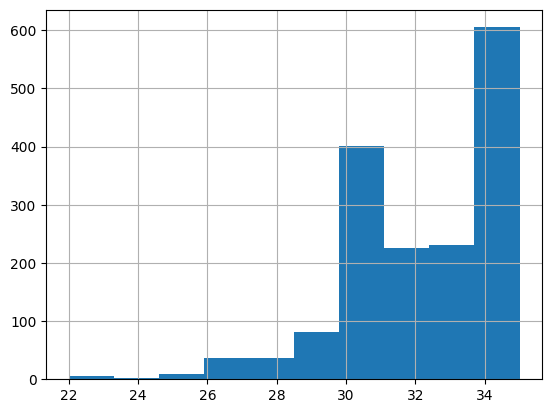

In [89]:
test['yards_shifted'].hist()

torch.Size([1, 20])
torch.Size([130])
torch.Size([1, 20])
torch.Size([130])
torch.Size([1, 20])
torch.Size([130])
torch.Size([1, 20])
torch.Size([130])
torch.Size([1, 20])
torch.Size([130])


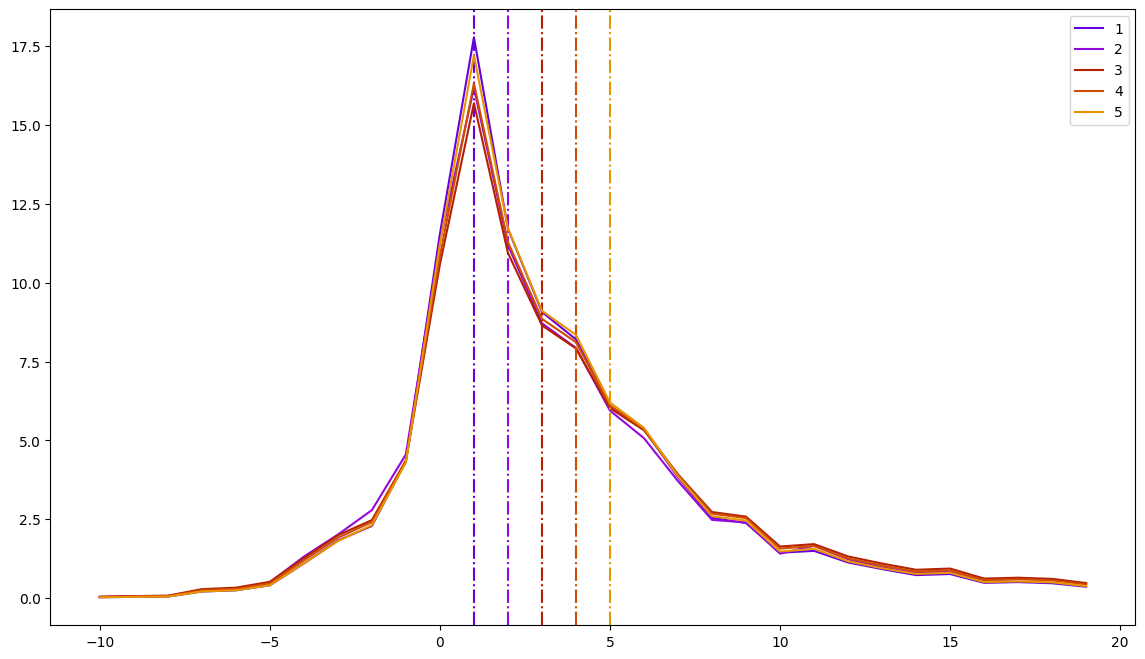

In [90]:
colormap = cm.gnuplot
plt.figure(figsize=(14, 8))
num_yardlines = 6
for yardline in range(1,num_yardlines):

    color = colormap(yardline / num_yardlines) 
    down=1
    test = small.loc[small.yardline_100==yardline]
    xx = torch.Tensor(test[rush_yards_cols].sample(1).values)
    print(xx.shape)
    with torch.no_grad():
        xy = rush_yards_model(xx)
        xy = (100 * F.softmax(xy,dim=1))[0]
        print(xy.shape)
        x_range = range(-10,20)
    plt.axvline(yardline, color=color, linestyle='-.')
    plt.plot(x_range, xy[20:50], label=yardline, color=color)

plt.legend()

In [91]:
test = small.loc[small.yardline_100==45].sample(1)
xx = torch.Tensor(test[rush_yards_cols].values)
xy = xy = torch.Tensor(test['yards_shifted'].values)

In [95]:
[print(a,b) for a,b in zip(list(xx[0]), rush_yards_cols)]
xy

tensor(45.) yardline_100
tensor(1.) down
tensor(0.) goal_to_go
tensor(10.) ydstogo
tensor(31.) posteam_score
tensor(21.) defteam_score
tensor(10.) score_differential
tensor(137.) quarter_seconds_remaining
tensor(137.) half_seconds_remaining
tensor(137.) game_seconds_remaining
tensor(5.) wind
tensor(50.) temp
tensor(-1.5000) spread_line
tensor(48.5000) total_line
tensor(5.0804) carries_roll
tensor(29.8177) rushing_yards_roll
tensor(7.0619) fantasy_points_ppr_roll
tensor(5.9653) yards_per_carry_roll
tensor(103.4286) rushing_yards_team_roll
tensor(117.7143) rushing_yards_opp_roll


tensor([35.])

In [104]:
xx[0][17] #127

tensor(5.9653)

opp_yards: 0 4.071
opp_yards: 1 4.074
opp_yards: 2 4.087
opp_yards: 3 4.072
opp_yards: 4 4.08
opp_yards: 5 4.082
opp_yards: 6 4.087
opp_yards: 7 4.058
opp_yards: 8 4.062
opp_yards: 9 4.071


(array([  1255.,   1166.,   5041., 402615., 474318.,  74893.,  19286.,
          7079.,   3671.,  10676.]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <BarContainer object of 10 artists>)

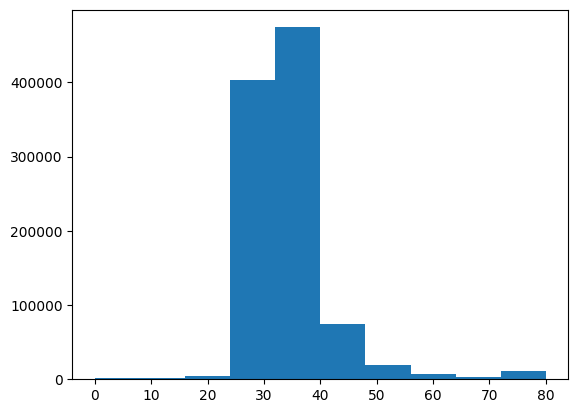

In [105]:
for ypc in range(0, 10, 1):
    xx[0][17] = torch.tensor(5)
    res = rush_yards_model(xx)
    res = F.softmax(res,dim=1)[0]
    samples = torch.clamp( torch.multinomial(res,1000000,replacement=True),max=80)
    avg = round(samples.double().mean().item()-30, 3)
    print(f'opp_yards: {ypc}',avg) # 3.34
plt.hist(samples)

In [106]:
samples.double().min()

tensor(0., dtype=torch.float64)

<Axes: >

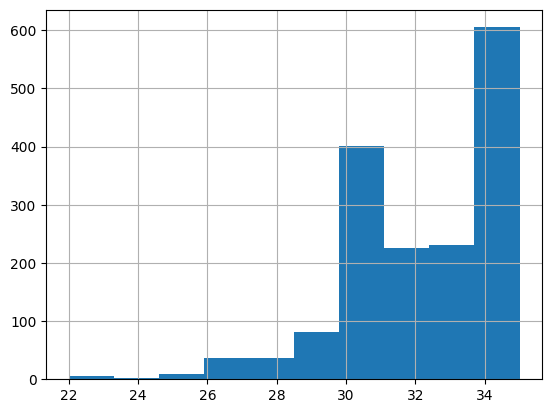

In [107]:
rushes.loc[rushes.yardline_100==5]['yards_shifted'].hist()

In [108]:
[x for x in pbp.columns if 'ard' in x]

['yardline_100',
 'yards_gained',
 'air_yards',
 'yards_after_catch',
 'passing_yards',
 'receiving_yards',
 'rushing_yards',
 'lateral_receiving_yards',
 'lateral_rushing_yards',
 'fumble_recovery_1_yards',
 'fumble_recovery_2_yards',
 'return_yards',
 'penalty_yards',
 'end_yard_line',
 'drive_yards_penalized',
 'drive_start_yard_line',
 'drive_end_yard_line',
 'xyac_mean_yardage',
 'xyac_median_yardage',
 'ngs_air_yards',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'receiving_yards_team_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'receiving_yards_opp_roll']

In [109]:
pbp.loc[
    (pbp['pass']==1) & 
    (pbp.pass_attempt==1)
    & (pbp.play_type=='run')
    ]['desc']

Series([], Name: desc, dtype: object)

In [110]:
passes = pbp.loc[
        (pbp['pass']==1) & 
    (pbp.pass_attempt==1) & 
    (pbp.air_yards >= -20)
    & (pbp.play_type=='pass')
].copy(deep=True).dropna(axis=1,how='all')

In [111]:
receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[[
    "season",
    "team_name",
    "week",
    "game_type",
    "gsis_id",
    "position",
    "depth_position",
    "full_name",
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
]]

In [112]:
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team_name", "season", "week", "gsis_id"],
)
passes


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,receiving_air_yards_roll,receiving_yards_after_catch_roll,receiving_first_downs_roll,target_share_roll,air_yards_share_roll,fantasy_points_ppr_roll
0,58.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,1.000000
1,103.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,3.000000,15.000000,43.000000,1.000000,226.000000,11.000000,2.000000,0.375000,0.548544,13.300000
2,132.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,4.000000,4.000000,40.000000,0.000000,3.000000,37.000000,2.000000,0.100000,0.007282,15.400000
3,177.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,7.000000,7.000000,132.000000,0.000000,72.000000,60.000000,6.000000,0.175000,0.174757,20.200001
4,254.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,10.000000,16.000000,119.000000,0.000000,162.000000,29.000000,5.000000,0.290909,0.429708,21.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275338,3812.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,3.595031,5.547692,38.746028,0.006583,47.391892,15.318911,1.831080,0.173739,0.183427,7.508952
275339,3869.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,1.947200,3.440166,30.823058,0.068518,-1.264536,32.557572,1.213335,0.109217,-0.009518,24.796145
275340,3894.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,1.947200,3.440166,30.823058,0.068518,-1.264536,32.557572,1.213335,0.109217,-0.009518,24.796145
275341,3953.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,1.204704,1.874108,9.224007,0.000000,10.269402,7.783754,0.441677,0.059160,0.035902,2.127105


In [113]:
passes = passes.loc[~passes.receptions_roll.isna()].copy()
#51456 

In [114]:
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [115]:
air_yards_cols = [
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
] + game_context_cols + ['passing_yards_opp_roll']

In [116]:
passes['target_share_roll'].isna().sum()

0

In [117]:
passes['air_yards_20'] = passes['air_yards'] + 20
data = passes[air_yards_cols + ['air_yards_20']].copy()
data = data.dropna()
X = torch.Tensor((data[air_yards_cols].values))
y = torch.tensor(data['air_yards_20'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(air_yards_cols)
y.shape

torch.Size([186032])

In [119]:
air_yards_model = train_model(X, y, num_feats, 119) # 3.327, 0.0865
air_yards_model = air_yards_model.to('cpu')

Epoch 1/20, Loss: 0.0125
Epoch 2/20, Loss: 0.0070
Epoch 3/20, Loss: 0.0069
Epoch 4/20, Loss: 0.0068
Epoch 5/20, Loss: 0.0067
Epoch 6/20, Loss: 0.0067
Epoch 7/20, Loss: 0.0067
Epoch 8/20, Loss: 0.0067
Epoch 9/20, Loss: 0.0067
Epoch 10/20, Loss: 0.0067
Epoch 11/20, Loss: 0.0067
Epoch 12/20, Loss: 0.0067
Epoch 13/20, Loss: 0.0067
Epoch 14/20, Loss: 0.0067
Epoch 15/20, Loss: 0.0067
Epoch 16/20, Loss: 0.0066
Epoch 17/20, Loss: 0.0066
Epoch 18/20, Loss: 0.0066
Epoch 19/20, Loss: 0.0066
Epoch 20/20, Loss: 0.0066
Test Loss: 3.5185, Test Accuracy: 0.0877


In [120]:
model_path = "models/air_yards.pt"
torch.save(air_yards_model.state_dict(), model_path)


feature_config = {
    'air_yards_cols':air_yards_cols,
    'air_yards_model_path': 'models/air_yards.pt',
    'run_yards_model_path': "models/run_yards_gained.pt"
}
feature_config

update_config(feature_config)

<Axes: >

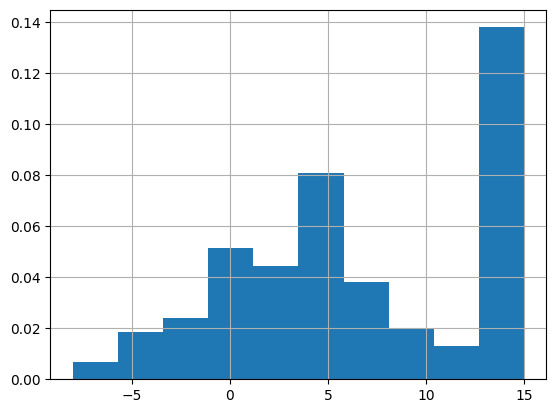

In [121]:
n = 15
ydl = data.loc[data.yardline_100==n]
(ydl['air_yards_20'] - 20).hist(density=True)

(array([0.00052429, 0.00050514, 0.00128257, 0.00510943, 0.02831543,
        0.02647829, 0.04368714, 0.03314171, 0.027868  , 0.11880229]),
 array([-20. , -16.5, -13. ,  -9.5,  -6. ,  -2.5,   1. ,   4.5,   8. ,
         11.5,  15. ]),
 <BarContainer object of 10 artists>)

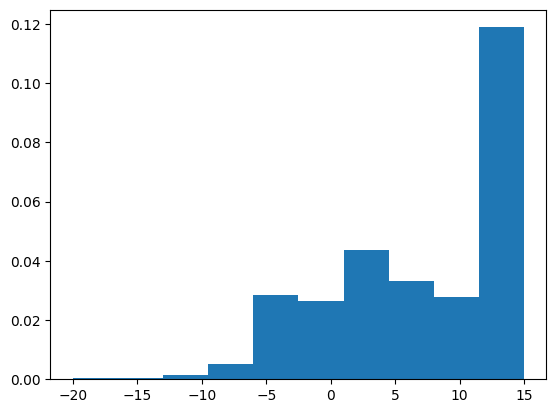

In [122]:
test_x = torch.Tensor(ydl.sample(100)[air_yards_cols].values)
res = air_yards_model(test_x)
res = F.softmax(res,dim=1)
samples = torch.clamp( torch.multinomial(res,10000,replacement=True), max=(n +20)).reshape(-1) - 20
plt.hist(samples,density=True)

In [123]:
passes[['yardline_100','yards_gained','air_yards','yards_after_catch', 'complete_pass']]

,yardline_100,yards_gained,air_yards,yards_after_catch,complete_pass
0,78.0,0.0,0.0,0.0,1.0
1,73.0,18.0,7.0,11.0,1.0
2,55.0,17.0,0.0,17.0,1.0
3,36.0,12.0,12.0,0.0,1.0
4,32.0,13.0,13.0,0.0,1.0
...,...,...,...,...,...
275338,49.0,16.0,16.0,0.0,1.0
275339,38.0,7.0,-3.0,10.0,1.0
275340,31.0,20.0,0.0,20.0,1.0
275341,21.0,11.0,-4.0,15.0,1.0


In [124]:
completions = passes.loc[passes.complete_pass==1].copy()
completions['yac_25'] = completions['yards_after_catch'] + 25

In [125]:
yac_cols = air_yards_cols + ['air_yards']
data = completions[yac_cols + ['yac_25']].copy()
data = data.dropna()
X = torch.Tensor((data[yac_cols].values))
y = torch.tensor(data['yac_25'].astype(int).values, dtype=torch.long)
obs = len(X)
air_yards_input = len(yac_cols)
X.shape

torch.Size([118726, 27])

In [131]:
yac_model = train_model(X, y, 27, 125)
yac_model = yac_model.to('cpu')

Epoch 1/20, Loss: 0.0136
Epoch 2/20, Loss: 0.0057
Epoch 3/20, Loss: 0.0055
Epoch 4/20, Loss: 0.0055
Epoch 5/20, Loss: 0.0054
Epoch 6/20, Loss: 0.0054
Epoch 7/20, Loss: 0.0054
Epoch 8/20, Loss: 0.0054
Epoch 9/20, Loss: 0.0054
Epoch 10/20, Loss: 0.0054
Epoch 11/20, Loss: 0.0054
Epoch 12/20, Loss: 0.0054
Epoch 13/20, Loss: 0.0053
Epoch 14/20, Loss: 0.0053
Epoch 15/20, Loss: 0.0053
Epoch 16/20, Loss: 0.0053
Epoch 17/20, Loss: 0.0053
Epoch 18/20, Loss: 0.0053
Epoch 19/20, Loss: 0.0053
Epoch 20/20, Loss: 0.0053
Test Loss: 2.7402, Test Accuracy: 0.2517


(array([0.00019912, 0.00016471, 0.00020265, 0.00017706, 0.00032529,
        0.00062912, 0.00366471, 0.12434794, 0.05739118, 0.10701588]),
 array([-25. , -21.6, -18.2, -14.8, -11.4,  -8. ,  -4.6,  -1.2,   2.2,
          5.6,   9. ]),
 <BarContainer object of 10 artists>)

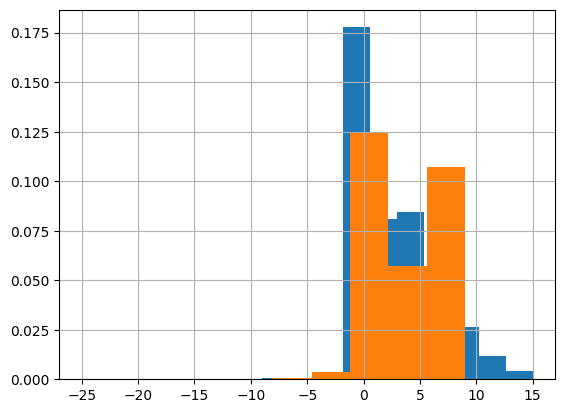

In [132]:
n = 9
ydl = data.loc[data.yardline_100==n]
(ydl['yac_25'] - 25).hist(density=True)
test_x = torch.Tensor(ydl.sample(100)[yac_cols].values)
res = yac_model(test_x)
res = F.softmax(res,dim=1)
samples = torch.clamp(torch.multinomial(res,10000,replacement=True).reshape(-1), max= (n+25)) - 25
plt.hist(samples,density=True)

In [133]:
model_path = "models/yac.pt"
torch.save(yac_model.state_dict(), model_path)


feature_config = {
    'yac_cols':yac_cols,
    'yac_path': 'models/yac.pt',
    'run_yards_model_path': "models/run_yards_gained.pt"
}
feature_config

update_config(feature_config)

In [134]:
pbp['desc'].sample(15)

224439    (5:29) 23-A.Foster left end to TEN 34 for -7 y...
115629    (12:34) 3-B.Weeden pass short right to 13-J.Go...
174208    (10:40) 21-F.Gore up the middle to WAS 26 for ...
82300     (4:22) 9-T.Romo pass short left to 28-F.Jones ...
195669    1-P.McAfee kicks 69 yards from IND 35 to PHI -...
354347    (1:13) (Shotgun) 29-D.Murray up the middle to ...
450236    (4:58) 28-R.Freeman left guard to MIN 47 for 2...
122556    (:43) (Shotgun) 8-S.Bradford pass incomplete s...
444430    (1:30) 8-K.Cousins pass short right to 84-I.Sm...
126701    (7:42) 8-M.Schaub pass short right to 23-A.Fos...
345489    4-R.Succop kicks 64 yards from TEN 35 to IND 1...
557686    (12:59) (Shotgun) 7-B.Roethlisberger pass shor...
265038    (13:29) 3-M.Bryant 46 yard field goal is No Go...
604873    (4:50) (Shotgun) 15-P.Mahomes scrambles right ...
97454     (11:37) 9-T.Romo pass short left to 29-D.Murra...
Name: desc, dtype: object

In [135]:
pbp.iloc[177294].dropna().to_dict()

{'play_id': 2570.0,
 'game_id': '2013_13_TB_CAR',
 'old_game_id': '2013120100',
 'home_team': 'CAR',
 'away_team': 'TB',
 'season_type': 'REG',
 'week': 13,
 'posteam': 'CAR',
 'posteam_type': 'home',
 'defteam': 'TB',
 'game_date': '2013-12-01',
 'quarter_seconds_remaining': 0.0,
 'half_seconds_remaining': 900.0,
 'game_seconds_remaining': 900.0,
 'game_half': 'Half2',
 'quarter_end': 1.0,
 'drive': 18.0,
 'sp': 0.0,
 'qtr': 3.0,
 'goal_to_go': 0,
 'time': '00:00',
 'yrdln': 'CAR 35',
 'ydstogo': 0.0,
 'ydsnet': 66.0,
 'desc': 'END QUARTER 3',
 'shotgun': 0.0,
 'no_huddle': 0.0,
 'qb_kneel': 0.0,
 'qb_spike': 0.0,
 'qb_scramble': 0.0,
 'home_timeouts_remaining': 3.0,
 'away_timeouts_remaining': 3.0,
 'posteam_timeouts_remaining': 3.0,
 'defteam_timeouts_remaining': 3.0,
 'total_home_score': 24.0,
 'total_away_score': 6.0,
 'posteam_score': 24.0,
 'defteam_score': 6.0,
 'score_differential': 18.0,
 'posteam_score_post': 24.0,
 'defteam_score_post': 6.0,
 'score_differential_post': 18.0

In [136]:
pbp.iloc[177294]['pass_attempt']

nan

In [137]:
list(pbp.loc[pbp.play_type=='run']['desc'].sample(15))

['(14:52) 28-A.Blue right guard pushed ob at PIT 18 for 48 yards (21-J.Haden).',
 '(2:30) 37-M.Gaskin left tackle to NYG 27 for 2 yards (99-L.Williams).',
 '(9:44) 14-K.Gainwell up the middle to PHI 36 for 1 yard (24-J.Abram).',
 '(10:14) 1-T.Etienne left end to JAX 33 for -1 yards (93-T.Tart).',
 '(3:40) 22-M.Ingram right tackle to TB 45 for 3 yards (58-K.Alexander).',
 '(2:08) 22-C.McCaffrey right end to SEA 29 for 4 yards (36-A.King; 72-A.Woods). SEA-72-A.Woods was injured during the play.',
 '(13:08) 29-D.Murray left tackle to DAL 10 for 1 yard (90-M.Brockers).',
 '(4:55) (Shotgun) 26-A.Peterson up the middle to WAS 38 for 1 yard (29-D.Bucannon).',
 '(13:42) 28-J.Mixon right guard to CIN 42 for -4 yards (98-S.Rankins). CIN-28-J.Mixon was injured during the play.',
 '(12:24) (Shotgun) 45-M.Reece right tackle to LV 47 for 5 yards (57-K.Brooking; 20-M.Adams).',
 '(6:29) (Shotgun) 23-T.Coleman left tackle to NYJ 33 for 3 yards (96-D.Barnett; 49-A.Singleton).',
 '(8:48) 33-D.Lewis left 

In [138]:
list(pbp.loc[(pbp.rusher_player_name=='J.Hurts') & (pbp.down==4) & (pbp.ydstogo == 1)]['desc'])

['(8:16) (Shotgun) 2-J.Hurts up the middle to NO 42 for 3 yards (43-M.Williams).',
 '(3:11) 2-J.Hurts up the middle to NO 40 for no gain (58-K.Alexander; 43-M.Williams).',
 '(10:26) 1-J.Hurts up the middle to PHI 35 for 1 yard (77-Q.Jefferson; 90-J.Hankins).',
 '(5:36) (No Huddle) 1-J.Hurts left guard to WAS 39 for 3 yards (95-C.Toohill).',
 '(13:00) (Shotgun) 1-J.Hurts scrambles right end for 1 yard, TOUCHDOWN.',
 '(1:06) 1-J.Hurts up the middle to DET 39 for 1 yard (55-D.Barnes).',
 '(12:51) (No Huddle) 1-J.Hurts up the middle to PHI 33 for 3 yards (95-R.Robertson-Harris; 41-J.Allen).',
 '(1:10) 1-J.Hurts up the middle to JAX 10 for 2 yards (41-J.Allen).',
 '(8:40) (No Huddle) 1-J.Hurts up the middle to ARI 1 for 2 yards (25-Z.Collins; 94-Z.Allen).',
 '(1:36) 1-J.Hurts up the middle to PHI 35 for 1 yard (58-C.Kirksey).',
 '(5:06) 1-J.Hurts FUMBLES (Aborted) at PHI 37, recovered by PHI-26-M.Sanders at PHI 37. 26-M.Sanders to PHI 37 for no gain (29-R.Douglas).',
 '(:54) 1-J.Hurts right